<a href="https://colab.research.google.com/github/Jathurshan0330/Image-Registration-ITK/blob/master/170248G_Image_Registration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get Requirements

In [1]:
from IPython.display import clear_output

In [2]:
!pip install itk itkwidgets ipywidgets
clear_output()

In [3]:
#Import Libraries
import sys
from distutils.version import StrictVersion as VS
import itk
import numpy as np
import itk
import itkwidgets
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
from seaborn.matrix import clustermap

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
if VS(itk.Version.GetITKVersion()) < VS("4.9.0"):
    print("ITK 4.9.0 is required.")
    sys.exit(1)

In [27]:
def plotting_images(img_list,title_list, cmap = 'gray'):
  fig, ax = plt.subplots(1,len(img_list), figsize=(20,8))
  for i in range(len(img_list)):
    ax[i].imshow(img_list[i], cmap = cmap, interpolation ='bilinear'), 
    ax[i].set_title(title_list[i],fontsize = 15),ax[i].axis('off')
  plt.show()

In [28]:
def interactive_plot(img_list,title_list, cmap = 'gray'):
  def plotting_images(slice):
    fig, ax = plt.subplots(1,len(img_list), figsize=(20,8))
    for i in range(len(img_list)):
      ax[i].imshow(img_list[i][slice], cmap = cmap, interpolation ='bilinear'), 
      ax[i].set_title(title_list[i],fontsize = 15),ax[i].axis('off')
    plt.show()
  select_slice = IntSlider(min=0, max=img_list[0].shape[0]-1, description='Select Slice', continuous_update=False)
  return interactive(plotting_images, slice=select_slice)


# Load Images 

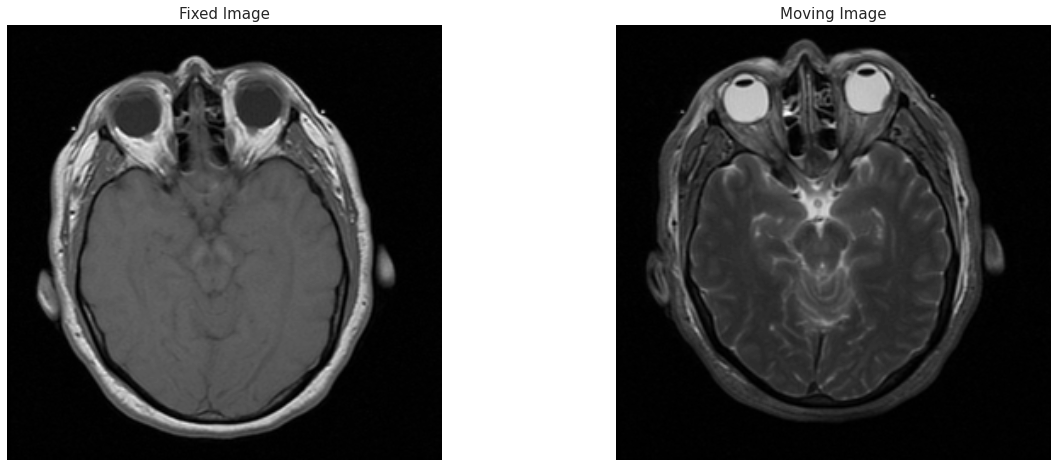

interactive(children=(IntSlider(value=0, continuous_update=False, description='Select Slice', max=32), Output(…

In [76]:
base = "/content/drive/MyDrive/Registration Data/"
fixed_image_file = base+"VF-MRT1-1014-1174.vtk"
moving_image_file = base+"VF-MRT2-1014-1174.vtk"
output_image_file  = base+"out.vtk"
img_before_file  = base+"img_before.vtk"
img_after_file  = base+"img_after.vtk"

fixed_image = itk.imread(fixed_image_file)
moving_image = itk.imread(moving_image_file)

slice = 20
plotting_images([fixed_image[slice],moving_image[slice]],["Fixed Image", "Moving Image"])
interactive_plot([fixed_image,moving_image],["Fixed Image", "Moving Image"])

# Image Registration

In [97]:
#Images and Output files
pixel_type = itk.F
fixed_image_file = base+"VF-MRT1-1014-1174.vtk"
moving_image_file = base+"VF-MRT2-1014-1174.vtk"
reg_image_file_trans  = base+"reg_trans.vtk"
# output_image_file_trans  = base+"out_trans.vtk"
diff_img_before_file_trans = base+"img_before_trans.vtk"
diff_img_after_file_trans  = base+"img_after_trans.vtk"

fixed_img = itk.imread(fixed_image_file, pixel_type)
moving_img = itk.imread(moving_image_file, pixel_type)

dim = fixed_img.GetImageDimension()
fixed_img_type = itk.Image[pixel_type, dim]
moving_img_type = itk.Image[pixel_type, dim]

print("Fixed Image ====================>")
print(f"Shape       : {fixed_img.shape} ")
print(f"Pixel Type  : {fixed_img_type} ")
print("Moving Image ===================>")
print(f"Shape       : {moving_img.shape} ")
print(f"Pixel Type  : {moving_img_type} ")

Fixed Image ====================>
Shape       : (33, 256, 256) 
Pixel Type  : <class 'itk.itkImagePython.itkImageF3'> 
Moving Image ===================>
Shape       : (63, 256, 256) 
Pixel Type  : <class 'itk.itkImagePython.itkImageF3'> 


In [98]:
########################### Transformation ###########################
transform_type = itk.TranslationTransform[itk.D,dim]
initial_transform = transform_type.New()

############################# Optimizer ##############################
opt = itk.RegularStepGradientDescentOptimizerv4.New( LearningRate=4,        ###
                                                    MinimumStepLength=0.0005,###
                                                    RelaxationFactor=0.5,   ###
                                                    NumberOfIterations=200) ###

############################## Metric ##################################
metric = itk.MattesMutualInformationImageToImageMetricv4[fixed_img_type, moving_img_type].New()
metric.SetNumberOfHistogramBins(24)  ####
metric.SetUseMovingImageGradientFilter(False)
metric.SetUseFixedImageGradientFilter(False)

########################### Registration ###############################
reg = itk.ImageRegistrationMethodv4[fixed_img_type, moving_img_type].New( FixedImage = fixed_img, 
                                                                          MovingImage = moving_img,
                                                                          Metric = metric, Optimizer=opt, 
                                                                          InitialTransform=initial_transform)

In [99]:
movingInitialTransform = transform_type.New()
initialParameters = movingInitialTransform.GetParameters()
initialParameters[0] = 0
initialParameters[1] = 0
movingInitialTransform.SetParameters(initialParameters)
reg.SetMovingInitialTransform(movingInitialTransform)



identityTransform = transform_type.New()
identityTransform.SetIdentity()
reg.SetFixedInitialTransform(identityTransform)

#------------------------------------
reg.SetNumberOfLevels(1)                  ###
reg.SetSmoothingSigmasPerLevel([0])       ###
reg.SetShrinkFactorsPerLevel([1])         ###
#------------------------------------



 Starting Registration ===========================>
Index : 0 -->  Metric : -0.363855   (X,Y,Z) : (0.256409 -3.813188 -1.180615)
Index : 1 -->  Metric : -0.470647   (X,Y,Z) : (0.366235 -7.714076 -2.058688)
Index : 2 -->  Metric : -0.628557   (X,Y,Z) : (-1.687360 -11.044031 -1.225537)
Index : 3 -->  Metric : -0.537375   (X,Y,Z) : (-0.179787 -9.731233 -1.164040)
Index : 4 -->  Metric : -0.609955   (X,Y,Z) : (0.170345 -7.762874 -1.109538)
Index : 5 -->  Metric : -0.632928   (X,Y,Z) : (0.065918 -8.747871 -1.246928)
Index : 6 -->  Metric : -0.641698   (X,Y,Z) : (0.084300 -8.248325 -1.257681)
Index : 7 -->  Metric : -0.646847   (X,Y,Z) : (0.126899 -8.487026 -1.318566)
Index : 8 -->  Metric : -0.645818   (X,Y,Z) : (0.088192 -8.368174 -1.319516)
Index : 9 -->  Metric : -0.647018   (X,Y,Z) : (0.118975 -8.249137 -1.342046)
Index : 10 -->  Metric : -0.647313   (X,Y,Z) : (0.104698 -8.309891 -1.345408)
Index : 11 -->  Metric : -0.647392   (X,Y,Z) : (0.087485 -8.369875 -1.348863)
Index : 12 -->  Met

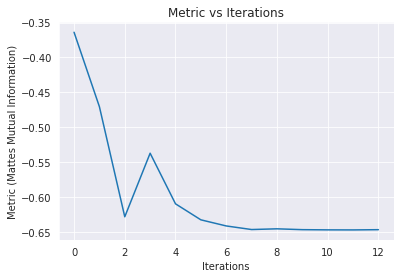

In [100]:
iter = []
val = []
def iterationUpdate():
    currentParameter = reg.GetTransform().GetParameters()
    iter.append(opt.GetCurrentIteration())
    val.append(opt.GetValue())
    print(
        "Index : %i -->  Metric : %f   (X,Y,Z) : (%f %f %f)"
        % (
            opt.GetCurrentIteration(),
            opt.GetValue(),
            currentParameter.GetElement(0),
            currentParameter.GetElement(1),
            currentParameter.GetElement(2),

        )
    )
    
iterationCommand = itk.PyCommand.New()
iterationCommand.SetCommandCallable(iterationUpdate)
opt.AddObserver(itk.IterationEvent(), iterationCommand)

print(" Starting Registration ===========================>")
reg.Update()
print(" Registration Completed ===========================>")




transform = reg.GetTransform()
finalParameters = transform.GetParameters()
translationAlongX = finalParameters.GetElement(0)
translationAlongY = finalParameters.GetElement(1)

numberOfIterations = opt.GetCurrentIteration()

bestValue = opt.GetValue()

print("Result:")
print(" Translation X = " + str(translationAlongX))
print(" Translation Y = " + str(translationAlongY))
print(" Iterations    = " + str(numberOfIterations))
print(" Metric value  = " + str(bestValue))
print("=============================================>")


plt.figure()
plt.plot(iter, val)
plt.xlabel("Iterations")
plt.ylabel("Metric (Mattes Mutual Information)")
plt.title("Metric vs Iterations")
plt.show()

In [101]:
CompositeTransformType = itk.CompositeTransform[itk.D, dim]
outputCompositeTransform = CompositeTransformType.New()
outputCompositeTransform.AddTransform(movingInitialTransform)
outputCompositeTransform.AddTransform(reg.GetModifiableTransform())

resampler = itk.ResampleImageFilter.New(Input = moving_img,
                                        Transform = outputCompositeTransform,
                                        UseReferenceImage = True,
                                        ReferenceImage = fixed_img)
resampler.SetDefaultPixelValue(100)

OutputPixelType = itk.F#ctype('unsigned char')
OutputImageType = itk.Image[OutputPixelType, dim]

caster = itk.CastImageFilter[fixed_img_type,
        OutputImageType].New(Input = resampler)

writer = itk.ImageFileWriter.New(Input=caster, FileName=reg_image_file_trans)
writer.SetFileName(reg_image_file_trans)
writer.Update()

difference = itk.SubtractImageFilter.New(Input1 = fixed_img,
                                         Input2 = resampler)

intensityRescaler = itk.RescaleIntensityImageFilter[fixed_img_type,
                    OutputImageType].New(
                        Input=difference,
                        OutputMinimum=itk.NumericTraits[OutputPixelType].min(),
                        OutputMaximum=itk.NumericTraits[OutputPixelType].max())

resampler.SetDefaultPixelValue(1)
writer.SetInput(intensityRescaler.GetOutput())
writer.SetFileName(diff_img_after_file_trans)
writer.Update()

resampler.SetTransform(identityTransform)
writer.SetFileName(diff_img_before_file_trans)
writer.Update()



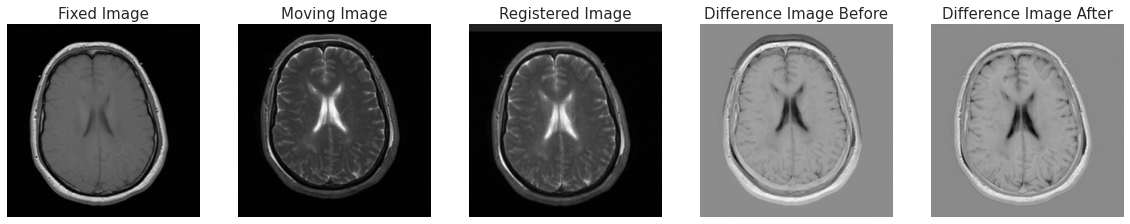

In [102]:
reg_image_trans = itk.imread(reg_image_file_trans)
img_before_trans = itk.imread(diff_img_before_file_trans)
img_after_trans = itk.imread(diff_img_after_file_trans)

plotting_images([fixed_image[slice],moving_image[slice],reg_image_trans[slice],img_before_trans[slice],img_after_trans[slice]],
                ["Fixed Image", "Moving Image","Registered Image","Difference Image Before"," Difference Image After"])

interactive_plot([fixed_image,moving_image,reg_image_trans,img_before_trans,img_after_trans],
                ["Fixed Image", "Moving Image","Registered Image","Difference Image Before","Difference Image After"])

In [103]:
def get_merged_img(img1, img2,num_regions = 4):
  img_new = itk.array_from_image(img1)
  if img1.shape[0]!=img2.shape[0]:
    img2 = itk.image_from_array(img2[:img1.shape[0]])
  size = img1.shape[-1]//num_regions
  for i in range (num_regions):
    for j in range(num_regions):
      if (i+j)%2 == 1:
        img_new[:,i*size:(i+1)*size,j*size:(j+1)*size] = itk.array_from_image(img2)[:,i*size:(i+1)*size,j*size:(j+1)*size]

  return img_new

In [106]:
before_img = get_merged_img(fixed_image, moving_image,num_regions = 2)
aft_img = get_merged_img(fixed_image, reg_image_trans,num_regions = 2)

before_img2 = get_merged_img(fixed_image, moving_image,num_regions = 4)
aft_img2 = get_merged_img(fixed_image, reg_image_trans,num_regions = 4)

interactive_plot([fixed_image,moving_image, before_img,aft_img,before_img2,aft_img2],
                ["Fixed Image", "Moving Image","Before Registration", "After Registration", "Before Registration", "After Registration"])

interactive(children=(IntSlider(value=0, continuous_update=False, description='Select Slice', max=32), Output(…